 1st oscillator: w=1.0 m=2.0 l=1.0 E: 0.6875 2.437498110766371
 2nd oscillator: w=10.0 m=1.0 l=0.0 E: 4.999999999999998 14.9999811076637
 Coupling matrix elements: 1st <0|Q|1> 0.5
 Coupling matrix elements: 2nd <0|Q|1> 0.22360679774997894
 Q1^2 matrix elements: 0.25 0.75
 Q2^2 matrix elements: 0.049999999999999996 0.14999999999999997
 Hamiltonian: 
[[ 5.6875      0.          0.          0.0559017 ]
 [ 0.          7.43749811  0.0559017   0.        ]
 [ 0.          0.0559017  15.68748111  0.        ]
 [ 0.0559017   0.          0.         17.43747922]]
 Eigenvalues: [ 5.68723405  7.43711934 15.68785988 17.43774517]
 Possible peaks: w(LFM)=1.0 w(HFM)=10.0 w(LFM+HFM)=11.0 w(HFM-LFM)=9.0
 Initial density matrix: [[9.99999975e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.51388108e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.69686720e-44 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.29348473e-52]] 


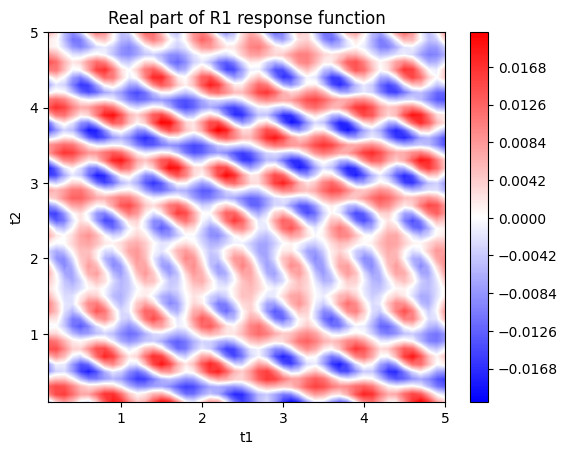

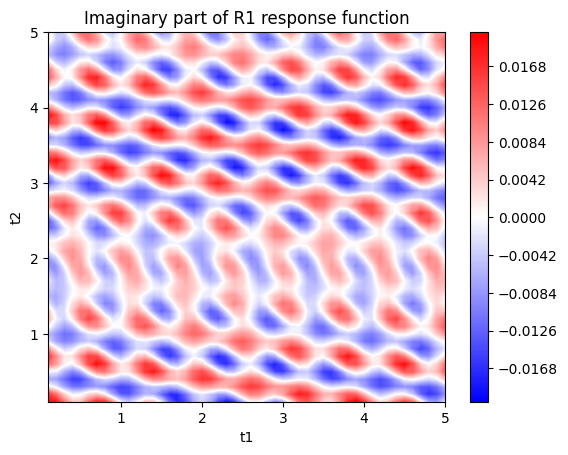

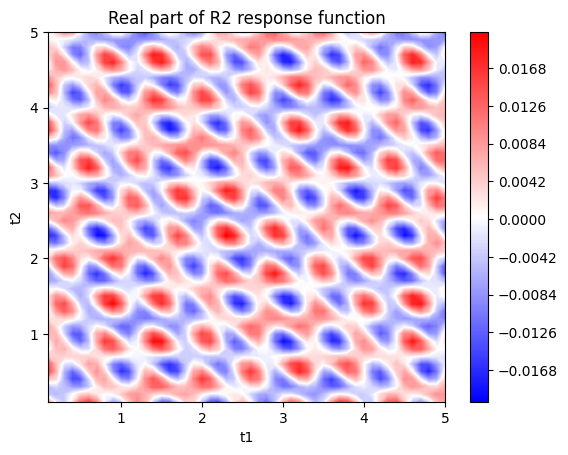

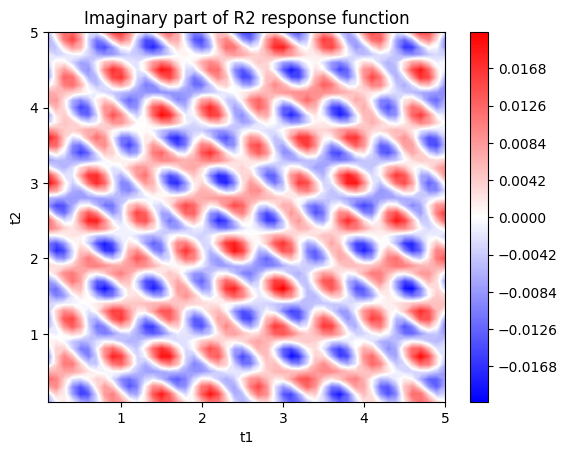

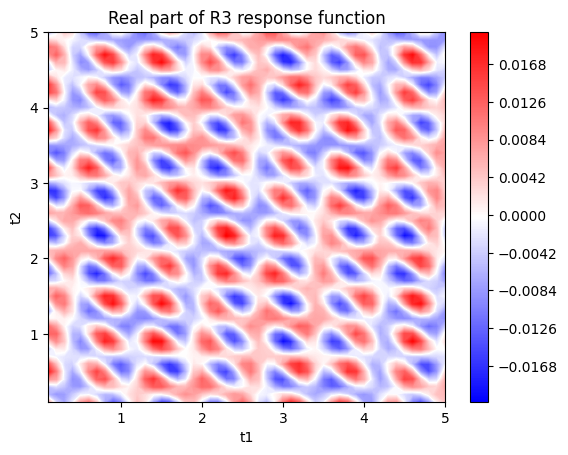

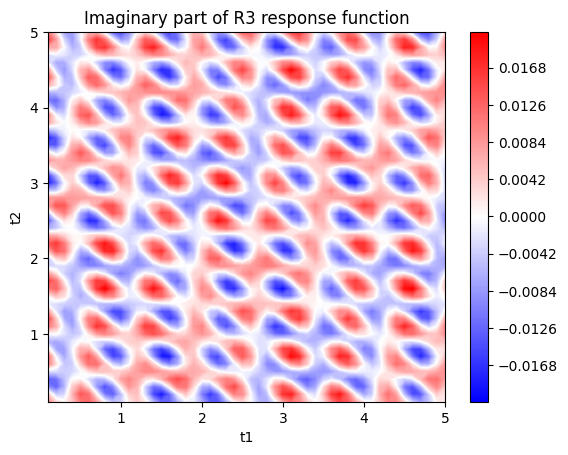

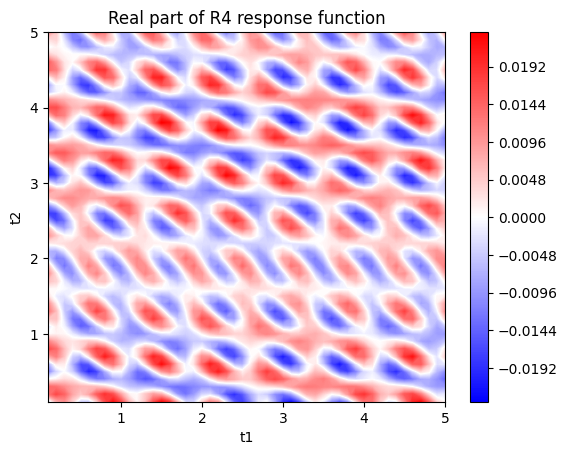

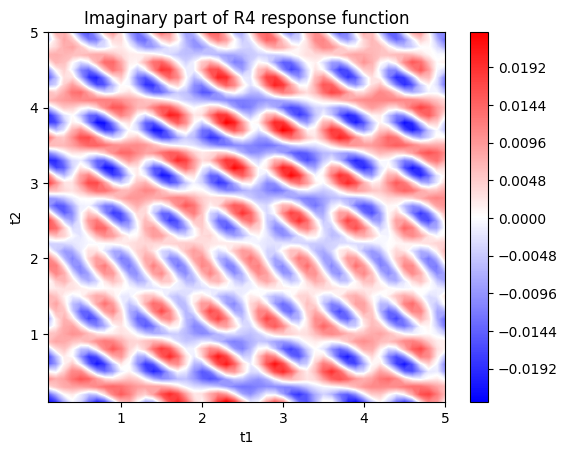

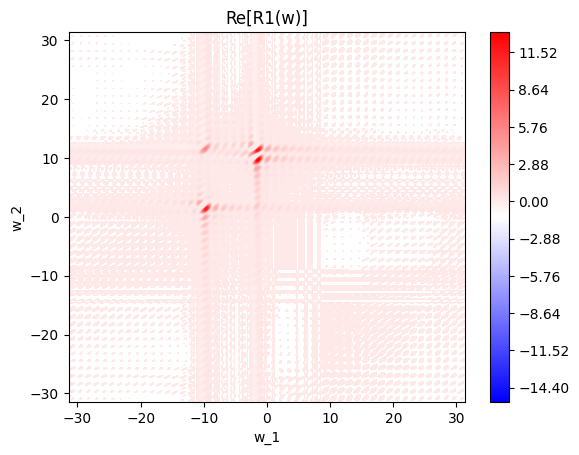

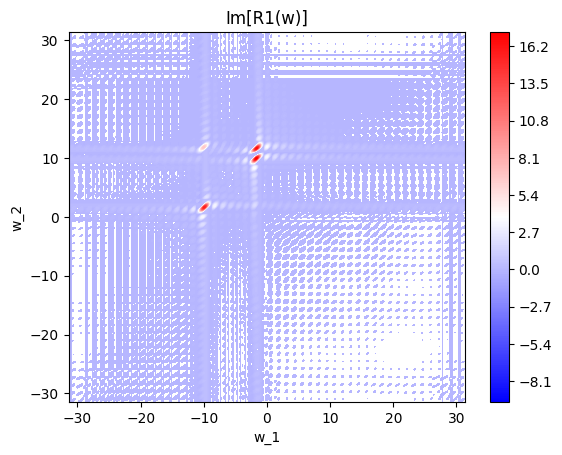

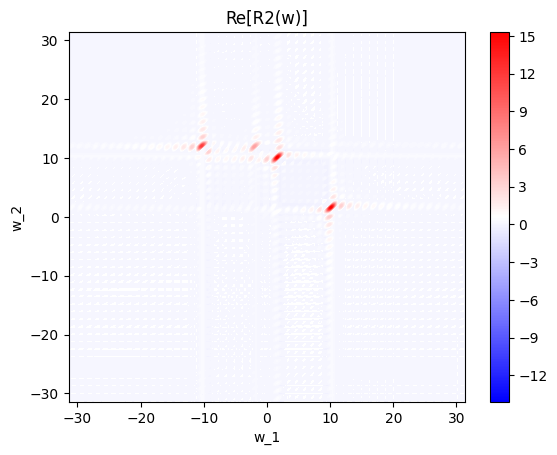

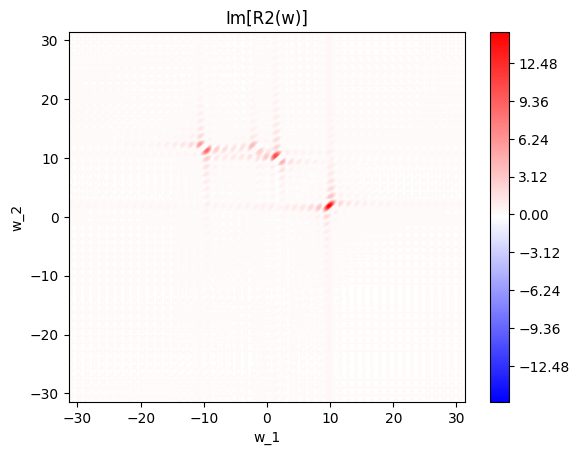

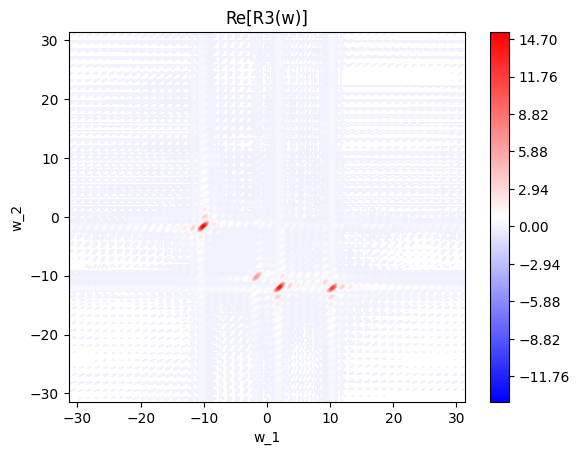

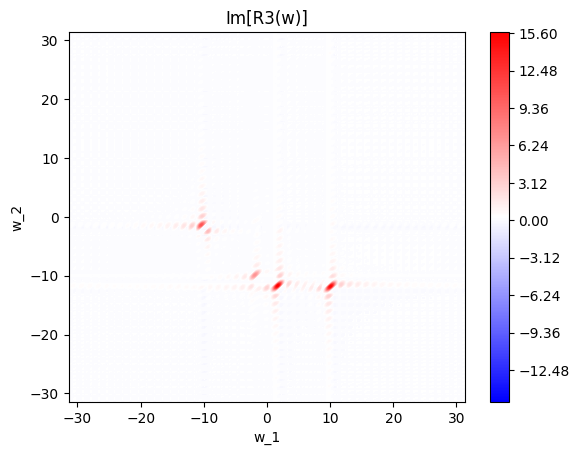

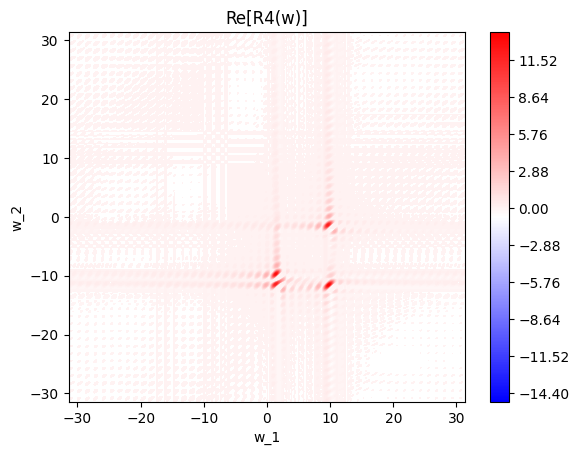

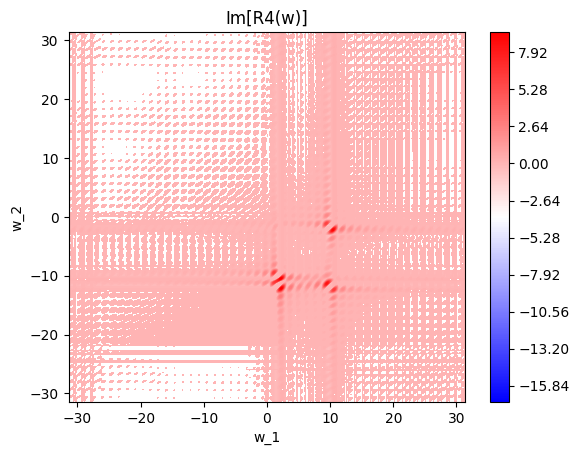

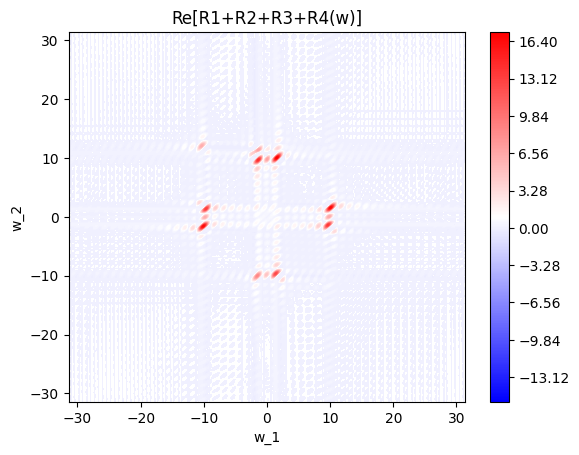

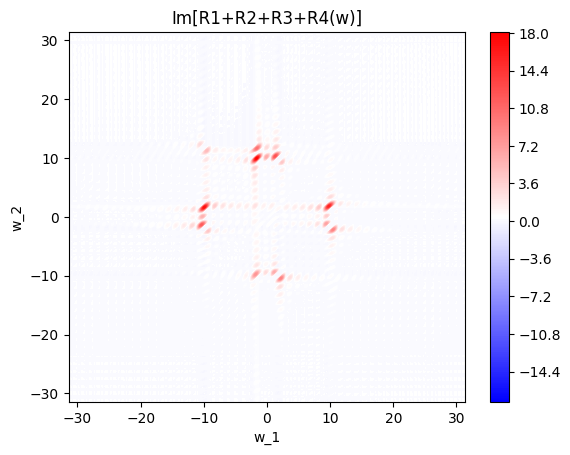

In [21]:
# Calculating:
#
# R(t_2,t_1) = (i\hbar)^2 <a(t2+t1)m(t1)m(t0)>
#
# for two coupled oscillators
#
import numpy as np
import scipy
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.fftpack import dst, idst

# constants (in a.u.)
hbar=1.0
kB=1.0

# integration limits
intL=8.0
# TO DO add plots of potentials

# "Low"-frequency mode
mass1 =2.0
omega1=1.0
lam1  =1.0

# "High"-frequency mode
mass2 =1.0
omega2=10.0
lam2  =0.0

# mode-mode coupling:
# kl*Q_1*Q_2 -> linear coupling is implemented
# ks*Q_1^2*Q_2 + ks*(Q_1^2*Q_2+Q_1*Q_2^2)
kl = 0.5
ks = 0.0

# dipole and polarizability:
# TO DO: add square dipoles
# mu = mu1*Q_1 + mu2*Q_2 + gm*Q_1*Q_2
mu1 = 1.0
mu2 = 1.0
gm = 0.5

# alpha = a1*Q_1 + a2*Q_2 + ga*Q_1*Q_2
a1 = 1.0
a2 = 1.0
# keep polarizability linear: a = Q_1 + Q_2 (no double quantum...)
ga = 0.0

# temperature in atomic units
T = 0.1

# time step for integrating
dt = 0.01

# Will perform integration over t1 and t2. Below are the parameters.
# t1 and t2 grids
t1max=5.0
t2max=5.0
dt1=0.05
dt2=0.05
T1s = np.arange(dt1,t1max+dt1,dt1)
T2s = np.arange(dt2,t2max+dt2,dt2)

#Fourier transform
NFFT=8192

# main code starts here
# 1. Calculate the Hamiltonian:
eps0_1 = Eps(mass1, omega1, lam1, 0, intL)
eps1_1 = Eps(mass1, omega1, lam1, 1, intL)

eps0_2 = Eps(mass2, omega2, lam2, 0, intL)
eps1_2 = Eps(mass2, omega2, lam2, 1, intL)

print (f" 1st oscillator: w={omega1} m={mass1} l={lam1} E: {eps0_1} {eps1_1}")
print (f" 2nd oscillator: w={omega2} m={mass2} l={lam2} E: {eps0_2} {eps1_2}")

q01_1, err = quad(Psi0QPsi1, -intL, intL, args=(mass1,omega1))
q01_2, err = quad(Psi0QPsi1, -intL, intL, args=(mass2,omega2))

# below are Q1^2 and Q2^2 terms which really is
# |q01_i|^2 but let's check anyways...
qq00_1, err = quad(Psi0Q2Psi0, -intL, intL, args=(mass1,omega1))
qq11_1, err = quad(Psi1Q2Psi1, -intL, intL, args=(mass1,omega1))
qq00_2, err = quad(Psi0Q2Psi0, -intL, intL, args=(mass2,omega2))
qq11_2, err = quad(Psi1Q2Psi1, -intL, intL, args=(mass2,omega2))

print (f" Coupling matrix elements: 1st <0|Q|1> {q01_1}")
print (f" Coupling matrix elements: 2nd <0|Q|1> {q01_2}")

print (f" Q1^2 matrix elements: {qq00_1} {qq11_1}")
print (f" Q2^2 matrix elements: {qq00_2} {qq11_2}")

# build the system Hamiltonian including all the energies and
# couplings
H = np.zeros((4,4))
H[0,0] = eps0_1 + eps0_2
H[0,1] = ks*q01_2*(q01_1)**2
H[0,2] = ks*q01_1*(q01_2)**2
H[0,3] = kl*q01_1*q01_2

H[1,0] = ks*q01_2*(q01_1)**2
H[1,1] = eps0_2 + eps1_1
H[1,2] = kl*q01_1*q01_2
H[1,3] = ks*q01_1*(q01_2)**2

H[2,0] = ks*q01_1*(q01_2)**2
H[2,1] = kl*q01_1*q01_2
H[2,2] = eps1_2 + eps0_1
H[2,3] = ks*q01_2*(q01_1)**2

H[3,0] = kl*q01_1*q01_2
H[3,1] = ks*q01_1*(q01_2)**2
H[3,2] = ks*q01_2*(q01_1)**2
H[3,3] = eps1_1 + eps1_2

print (" Hamiltonian: ")
print (H)

# eigensystem
evals, evecs = np.linalg.eigh(H)

print (f" Eigenvalues: {evals}")

print (f" Possible peaks: w(LFM)={omega1} w(HFM)={omega2} w(LFM+HFM)={omega1+omega2} w(HFM-LFM)={omega2-omega1}")

# determine populations from eigenvalues
RHO0 = rho0(evals,1.0/(kB*T))

print (f" Initial density matrix: {RHO0} ")

# Dipole and polarizability matrices
MU = np.zeros((4,4))
MU[0,1] = mu1*q01_1
MU[0,2] = mu2*q01_2
MU[0,3] = gm*q01_1*q01_2
MU[1,0] = mu1*q01_1
MU[1,2] = gm*q01_1*q01_2
MU[1,3] = mu2*q01_2
MU[2,0] = mu2*q01_2
MU[2,1] = gm*q01_1*q01_2
MU[2,3] = mu1*q01_2
MU[3,0] = gm*q01_1*q01_2
MU[3,1] = mu1*q01_2
MU[3,2] = mu1*q01_1

ALPHA = np.zeros((4,4))
ALPHA[0,1] = a1*q01_1
ALPHA[0,2] = a2*q01_2
ALPHA[0,3] = ga*q01_1*q01_2
ALPHA[1,0] = a1*q01_1
ALPHA[1,2] = ga*q01_1*q01_2
ALPHA[1,3] = a2*q01_2
ALPHA[2,0] = a2*q01_2
ALPHA[2,1] = ga*q01_1*q01_2
ALPHA[2,3] = a1*q01_2
ALPHA[3,0] = ga*q01_1*q01_2
ALPHA[3,1] = a2*q01_2
ALPHA[3,2] = a1*q01_1

# convert dipole moment and polarizability matrices
MUB = np.dot(np.dot(evecs.T,MU),evecs)
ALPHAB = np.dot(np.dot(evecs.T,ALPHA),evecs)

#print (MU)

# ready to simulate spectra
neiH = PROPAGATOR(evals,dt)
peiH = np.conj(neiH)

# response function
R1 = np.zeros((len(T1s),len(T2s)),dtype=np.complex128)
R2 = np.zeros((len(T1s),len(T2s)),dtype=np.complex128)
R3 = np.zeros((len(T1s),len(T2s)),dtype=np.complex128)
R4 = np.zeros((len(T1s),len(T2s)),dtype=np.complex128)

ihbar2= (1j/hbar)**2

# loop over t1 and t2
for ind1,t1 in enumerate(T1s):
  nt1steps=int(t1/dt)

  rhot1R1 = np.zeros((4,4,nt1steps),dtype=np.complex128)
  rhot1R2 = np.zeros((4,4,nt1steps),dtype=np.complex128)
  rhot1R3 = np.zeros((4,4,nt1steps),dtype=np.complex128)
  rhot1R4 = np.zeros((4,4,nt1steps),dtype=np.complex128)

  rhot1R1[:,:,0] = np.dot(MUB,RHO0)
  rhot1R2[:,:,0] = np.dot(MUB,RHO0)
  rhot1R3[:,:,0] = np.dot(RHO0,MUB)
  rhot1R4[:,:,0] = np.dot(RHO0,MUB)

  for nt1 in range(1,nt1steps):

    rhot1R1[:,:,nt1] = np.dot(np.dot(neiH,rhot1R1[:,:,nt1-1]),peiH)
    rhot1R2[:,:,nt1] = np.dot(np.dot(neiH,rhot1R2[:,:,nt1-1]),peiH)
    rhot1R3[:,:,nt1] = np.dot(np.dot(neiH,rhot1R3[:,:,nt1-1]),peiH)
    rhot1R4[:,:,nt1] = np.dot(np.dot(neiH,rhot1R4[:,:,nt1-1]),peiH)

  for ind2,t2 in enumerate(T2s):
    nt2steps=int(t2/dt)

    rhot2R1 = np.zeros((4,4,nt2steps),dtype=np.complex128)
    rhot2R2 = np.zeros((4,4,nt2steps),dtype=np.complex128)
    rhot2R3 = np.zeros((4,4,nt2steps),dtype=np.complex128)
    rhot2R4 = np.zeros((4,4,nt2steps),dtype=np.complex128)

    rhot2R1[:,:,0] = np.dot(MUB,rhot1R1[:,:,-1])
    rhot2R2[:,:,0] = np.dot(rhot1R2[:,:,-1],MUB)
    rhot2R3[:,:,0] = np.dot(MUB,rhot1R3[:,:,-1])
    rhot2R4[:,:,0] = np.dot(rhot1R4[:,:,-1],MUB)

    for nt2 in range(1,nt2steps):
      rhot2R1[:,:,nt2] = np.dot(np.dot(neiH,rhot2R1[:,:,nt2-1]),peiH)
      rhot2R2[:,:,nt2] = np.dot(np.dot(neiH,rhot2R2[:,:,nt2-1]),peiH)
      rhot2R3[:,:,nt2] = np.dot(np.dot(neiH,rhot2R3[:,:,nt2-1]),peiH)
      rhot2R4[:,:,nt2] = np.dot(np.dot(neiH,rhot2R4[:,:,nt2-1]),peiH)

    R1[ind1,ind2] = ihbar2*np.trace(np.dot(ALPHAB,rhot2R1[:,:,-1]))
    R2[ind1,ind2] = -ihbar2*np.trace(np.dot(ALPHAB,rhot2R2[:,:,-1]))
    R3[ind1,ind2] = -ihbar2*np.trace(np.dot(ALPHAB,rhot2R3[:,:,-1]))
    R4[ind1,ind2] = ihbar2*np.trace(np.dot(ALPHAB,rhot2R4[:,:,-1]))

# plot response function
plotR(T1s,T2s,np.real(R1),'Real part of R1 response function','t1','t2')
plotR(T1s,T2s,np.imag(R1),'Imaginary part of R1 response function','t1','t2')

plotR(T1s,T2s,np.real(R2),'Real part of R2 response function','t1','t2')
plotR(T1s,T2s,np.imag(R2),'Imaginary part of R2 response function','t1','t2')

plotR(T1s,T2s,np.real(R3),'Real part of R3 response function','t1','t2')
plotR(T1s,T2s,np.imag(R3),'Imaginary part of R3 response function','t1','t2')

plotR(T1s,T2s,np.real(R4),'Real part of R4 response function','t1','t2')
plotR(T1s,T2s,np.imag(R4),'Imaginary part of R4 response function','t1','t2')

Fourier(T1s,T2s,NFFT,R1,dt1,"R1")
Fourier(T1s,T2s,NFFT,R2,dt1,"R2")
Fourier(T1s,T2s,NFFT,R3,dt1,"R3")
Fourier(T1s,T2s,NFFT,R4,dt1,"R4")
Fourier(T1s,T2s,NFFT,R1+R2+R3+R4,dt1,"R1+R2+R3+R4")

Simulating IR-IR-VIS

In [1]:
def Fourier(T1s,T2s,NFFT,R1,dt,text):
  """
    Fourier transform
  """
  FFTIn = np.zeros((NFFT,NFFT),dtype=np.complex128)
  FFTIn[:len(T1s),:len(T2s)] = R1

  # discrete sin transform in 2D
  #FFTOut = _dst2(FFTIn)
  FFTOut = np.fft.fft2(FFTIn)

  res = np.zeros((NFFT,NFFT),dtype=np.complex128)
  for i in range(NFFT):
    for j in range(NFFT):
      if i==0:
        res[i,j] = FFTOut[i,j]
      else:
        res[i,j] = FFTOut[(NFFT-i),j]

  # define frequency grid:
  scale = dt*NFFT/(2.0*np.pi*hbar*np.sqrt(NFFT))
  omegas = np.zeros((NFFT))

  for i in range(int(NFFT/2),NFFT,1):
    omegas[i] = 2.0*np.pi*hbar*(i-NFFT)/(NFFT*dt)

  for i in range(int(NFFT/2)):
    omegas[i] = 2.0*np.pi*hbar*i/(NFFT*dt)

  plotR(omegas,omegas,scale*np.real(res),f'Re[{text}(w)]','w_1','w_2')
  plotR(omegas,omegas,scale*np.imag(res),f'Im[{text}(w)]','w_1','w_2')

In [2]:
def potential(mass,omega,lam,x):
  """
    Potential energy function of the LFM
    x - coordinate.

    TO DO:
    - parameters in atomic units
  """
  return mass*omega**2*x**2/2.0+lam*x**4

In [3]:
def HFM_LFMcoupling(k,Q1,Q2):
  """
    Hamiltonian coupling between HFM and LFM:
    k - coupling stretngth
  """
  return k*Q1*Q2

In [4]:
def Psi0(mass,omega,x):
  """
    Harmonic oscillator ground state
    using atomic units, so hbar=1
  """
  q = mass*omega/hbar
  return (q/np.pi)**(1/4)*np.exp(-q*x**2/2.0)*np.polynomial.hermite.hermval(np.sqrt(q)*x,[1])

In [5]:
def Psi1(mass,omega,x):
  """
    Harmonic oscillator first excited state
    using atomic units, so hbar=1
  """
  q = mass*omega/hbar
  return (1.0/np.sqrt(2))*(q/np.pi)**(1/4)*np.exp(-q*x**2/2.0)*np.polynomial.hermite.hermval(np.sqrt(q)*x,[0,1])

In [6]:
def d2Psi0dQ2(mass,omega,x):
  """
    Second derivative of Psi_0 w.r.t. coordinate
  """
  q=mass*omega/hbar
  return -np.exp(-q*x**2/2.0)*np.pi*(q/np.pi)**(5/4)*(hbar-mass*omega*x**2)/hbar

In [7]:
def d2Psi1dQ2(mass,omega,x):
  """
    Second derivative of Psi_1 w.r.t. coordinate
  """
  q=mass*omega/hbar
  return 1.41421*np.exp(-q*x**2/2.0)*q**(3/2)*(q/np.pi)**(1/4)*x*(-3.0*hbar+mass*omega*x**2)/hbar

In [8]:
def Eps(mass,omega,lam,state,intL):
  """
    Calculate eigenvalues of the Harmonic oscillator
  """
  if state==0:
    res1, err1 = quad(psi0vpsi0, -intL, intL, args=(mass,omega,lam))
    res2, err2 = quad(psi0d2psi0dq2, -intL, intL, args=(mass,omega))
  elif state==1:
    res1, err1 = quad(psi1vpsi1, -intL, intL, args=(mass,omega,lam))
    res2, err2 = quad(psi1d2psi1dq2, -intL, intL, args=(mass,omega))
  else:
    print ("wrong state in Eps")
    exit
  return res1-hbar**2*res2/(2.0*mass)

In [9]:
def psi0vpsi0(x,mass,omega,lam):
  """
    function Psi_0*V*Psi_0 for integration
  """
  return Psi0(mass,omega,x)*potential(mass,omega,lam,x)*Psi0(mass,omega,x)

In [10]:
def psi1vpsi1(x,mass,omega,lam):
  """
    function Psi_1*V*Psi_1 for integration
  """
  return Psi1(mass,omega,x)*potential(mass,omega,lam,x)*Psi1(mass,omega,x)

In [11]:
def psi0d2psi0dq2(x,mass,omega):
  """
    function Psi0*D[D[Psi0],x]
  """
  return Psi0(mass,omega,x)*d2Psi0dQ2(mass,omega,x)

In [12]:
def psi1d2psi1dq2(x,mass,omega):
  """
    function Psi1*D[D[Psi1],x]
  """
  return Psi1(mass,omega,x)*d2Psi1dQ2(mass,omega,x)

In [13]:
def Psi0QPsi1(x,mass,omega):
  """
    <Psi_0|x|Psi_1> for harmonic oscillator
  """
  return Psi0(mass,omega,x)*x*Psi1(mass,omega,x)

In [14]:
def Psi0Q2Psi0(x,mass,omega):
  """
    <Psi_0|x^2|Psi_0> for harmonic oscillator
  """
  return Psi0(mass,omega,x)*x*x*Psi0(mass,omega,x)

In [15]:
def Psi1Q2Psi1(x,mass,omega):
  """
    <Psi_1|x^2|Psi_1> for harmonic oscillator
  """
  return Psi1(mass,omega,x)*x*x*Psi1(mass,omega,x)

In [16]:
def rho0(evals,beta):
  """
    Boltzmann distribution
  """
  Z=np.trace(np.diag(np.exp(-beta*evals)))
  return np.diag(np.exp(-beta*evals)/Z)

In [17]:
def PROPAGATOR(evals,dt):
  return np.diag(np.exp(-1j*dt*evals/hbar))

In [18]:
def plotR(t1,t2,R,title,xlabel,ylabel):
  """
    contour plot the response function
  """
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  X, Y = np.meshgrid(t1, t2)

  plt.contourf(X, Y, R, 500, cmap='bwr')
  plt.colorbar()
  plt.show()

In [19]:
def _dst2(x, type=2):
    """
    Perform 2D Discrete Sine Transform
    """
    M, N = x.shape
    tmp = dst(x, type=type, axis=0)
    return dst(tmp, type=type, axis=1)